## Toshimaku Real Estate 1m Data

*The dataset used in this notebook includes price values below $1 million (approx. 90\% of the original dataset)*

Notebook Author: NGUYEN Dai Truong Thanh

Ritsumeikan Asia Pacific University

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pandas.plotting import scatter_matrix
from scipy import stats
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print("Libraries imported.")
print(tf.__version__)

Libraries imported.
2.3.1


In [2]:
path = "../input/toshima-data/toshimaku_cleaned_data_1m.csv"

toshima_data = pd.read_csv(path, index_col=0)
toshima_data.head(2)

,location,nearest_station,distance_to_station,layout,area,construction_year,building_structure,use,city_planning,maximum_coverage_ratio,maximum_floor_area_ratio,renovation,building_age,price
0,Ikebukuro,Ikebukuro,8,1K,15,1985,SRC,Other,Commercial Zone,0.8,6.0,Not yet,35,116400.0
1,Ikebukuro,Ikebukuro,11,1K,20,2010,RC,House,Neighborhood Commercial Zone,0.8,4.0,Not yet,10,164900.0


In [3]:
toshima_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 0 to 7373
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   location                  7374 non-null   object 
 1   nearest_station           7374 non-null   object 
 2   distance_to_station       7374 non-null   int64  
 3   layout                    7374 non-null   object 
 4   area                      7374 non-null   int64  
 5   construction_year         7374 non-null   int64  
 6   building_structure        7374 non-null   object 
 7   use                       7374 non-null   object 
 8   city_planning             7374 non-null   object 
 9   maximum_coverage_ratio    7374 non-null   float64
 10  maximum_floor_area_ratio  7374 non-null   float64
 11  renovation                7374 non-null   object 
 12  building_age              7374 non-null   int64  
 13  price                     7374 non-null   float64
dtypes: float

In [4]:
selected_columns = ["distance_to_station","area","maximum_coverage_ratio",
                    "maximum_floor_area_ratio","building_age","price"]

attributes = ["distance_to_station","area","maximum_coverage_ratio",
                    "maximum_floor_area_ratio","building_age"]

label = "price"

In [5]:
dataset = toshima_data[selected_columns].copy()

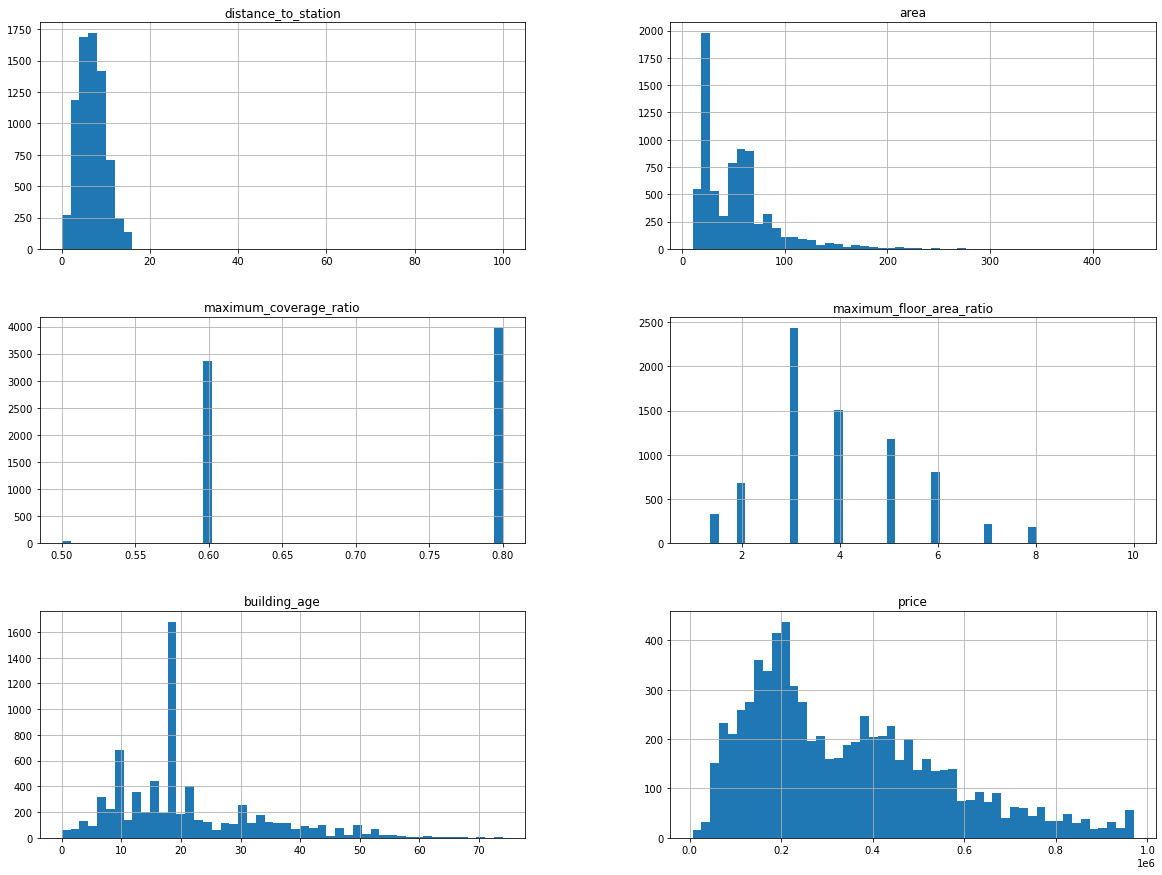

In [6]:
# historgram plots

dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# check for correlations 

corr_matrix = dataset.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price                       1.000000
area                        0.738507
distance_to_station         0.006293
maximum_floor_area_ratio   -0.236705
maximum_coverage_ratio     -0.241466
building_age               -0.293058
Name: price, dtype: float64


* area has quite **strong positive** correlation with price
* distance_to_station has **very weak positive** correlation with price
* maximum_coverage_ratio, maximum_floor_area_ratio, and building_age have **weak negative** correlations with price

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf418f91d0>,
      dtype=object)

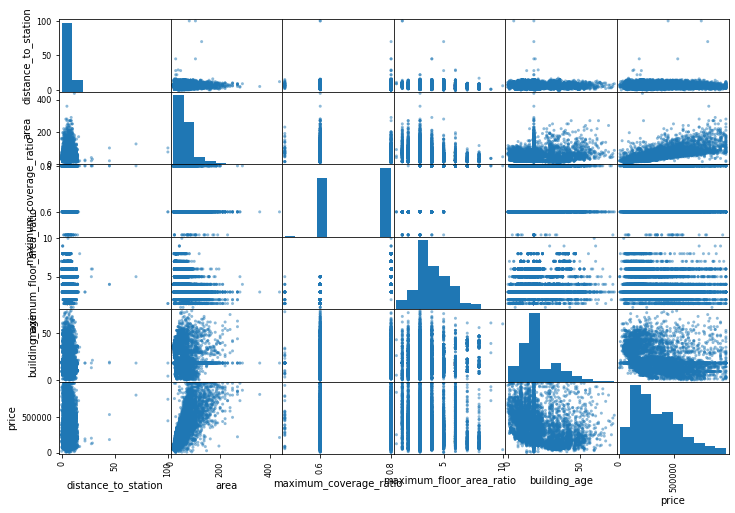

In [8]:
scatter_matrix(dataset, figsize=(12, 8))

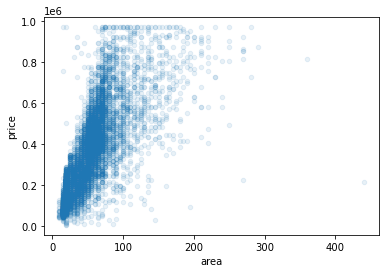

In [9]:
dataset.plot(kind="scatter", x="area", y="price",
             alpha=0.1)

# the price value increases as area value increases

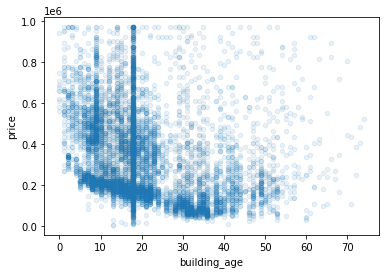

In [10]:
dataset.plot(kind="scatter", x="building_age", y="price",
             alpha=0.1)

# the price value decreases as buidling age increases
# we can see 2 vertical lines around 10 year-old-building and 20 year-old-building

In [11]:
# split the dataset

train_set, test_set = train_test_split(dataset, test_size=0.1, random_state=42)
print(len(train_set))
print(len(test_set))

6636
738


### Linear Regression Models

In [12]:
def lin_reg(x):
    lm = LinearRegression()

    pearson_coef, p_value = stats.pearsonr(train_set[x], train_set["price"])
    print("Pearson Coefficient =",pearson_coef, "and P-value =", p_value)
    print("")

    lm.fit(train_set[[x]], train_set["price"])

    print("Slope: ", lm.coef_)
    print("Intercept: ", lm.intercept_)
    print("")
    if float(lm.coef_) >= 0:
        print("Linear Model: price =", lm.intercept_, "+", float(lm.coef_), "*", x)
    else:
        print("Linear Model: price =", lm.intercept_, float(lm.coef_), "*", x)

In [13]:
area_lm = lin_reg("area")

Pearson Coefficient = 0.7366994858388467 and P-value = 0.0

Slope:  [4273.6841853]
Intercept:  121723.21685639836

Linear Model: price = 121723.21685639836 + 4273.684185301328 * area


In [14]:
building_age_lm = lin_reg("building_age")

Pearson Coefficient = -0.2946334255539071 and P-value = 5.0605588123217925e-133

Slope:  [-5099.98242918]
Intercept:  449658.481956314

Linear Model: price = 449658.481956314 -5099.982429180857 * building_age


### Multiple Linear Regression Model

In [15]:
# Multiple linear regression models using all numerical attributes. 

mul_reg = LinearRegression()

mul_reg.fit(train_set[attributes], train_set[label])

print("Slope: ", mul_reg.coef_)
print("Intercept: ", mul_reg.intercept_)

Slope:  [ -2709.67039621   4379.97117183 -93394.62267069   9824.16541746
  -5517.20584895]
Intercept:  275513.7090083947


**Multiple linear regression model to predict price of a building in Toshima-ku:**

> price = 275513.71 - 2709.67\*distance_to_station + 4379.97\*area - 93394.62\*maximum_coverage_ratio + 9824.17\*maximum_floor_area_ratio - 5517.21\*building_age

In [16]:
lin_predictions = mul_reg.predict(train_set[attributes])
lin_mse = mean_squared_error(train_set[label], lin_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

126679.88443319968

In [17]:
# function that compares predictions vs actual values

def plot_com(actual, preds):
    plt.figure(figsize=(12, 8))

    ax1 = sns.distplot(actual, hist=False, color="r", label="Actual Value")
    sns.distplot(preds, hist=False, color="b", label="Fitted Values" , ax=ax1)

    plt.title('Actual vs Fitted Values for Price')
    plt.xlabel('Price (in dollars)')

    plt.show()
    plt.close()

The mul_reg model has **a typical prediction error of \$126,680** for the price ranging from **\$6,402 - 970,000**

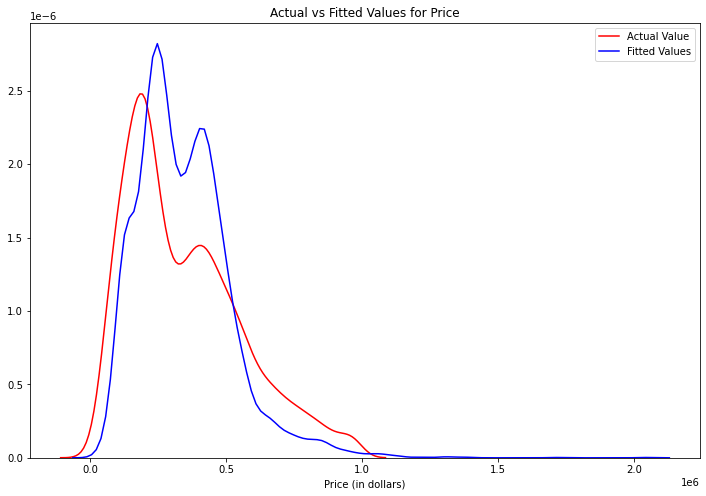

In [18]:
plot_com(train_set[label], lin_predictions)

### Decision Tree Regression Model

In [19]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set[attributes], train_set[label])

DecisionTreeRegressor(random_state=42)

In [20]:
tree_predictions = tree_reg.predict(train_set[attributes])
tree_mse = mean_squared_error(train_set[label], tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

44196.75724222457

The tree_reg model has **a typical prediction error of \$44,197**

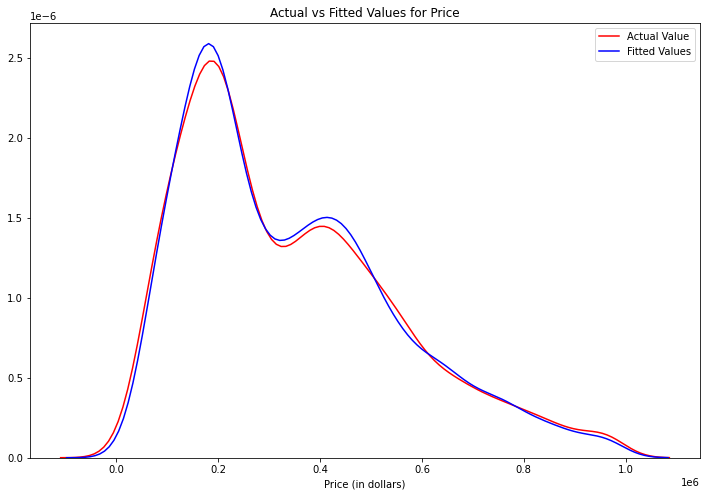

In [21]:
plot_com(train_set[label], tree_predictions)

### Random Forest Regression Model

In [22]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_set[attributes], train_set[label])

RandomForestRegressor(random_state=42)

In [23]:
forest_predictions = forest_reg.predict(train_set[attributes])
forest_mse = mean_squared_error(train_set[label], forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

54716.78354598624

The forest_reg model has **a typical prediction error of \$54,717**

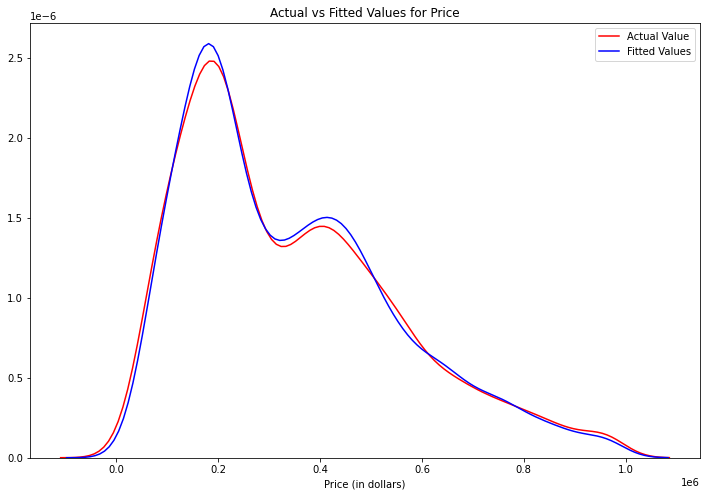

In [24]:
plot_com(train_set[label], tree_predictions)

### Linear Regression Model with Polynomial Features

Using Transformation Pipelines

In [25]:
input = [("scale",StandardScaler()),
         ("polynomial",PolynomialFeatures(include_bias=False)),
         ("model",LinearRegression())]

pipe = Pipeline(input)
pipe.fit(train_set[attributes], train_set[label])

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [26]:
pipe_predictions = pipe.predict(train_set[attributes])
pipe_mse = mean_squared_error(train_set[label], pipe_predictions)
pipe_rmse = np.sqrt(pipe_mse)
pipe_rmse

108688.3563620356

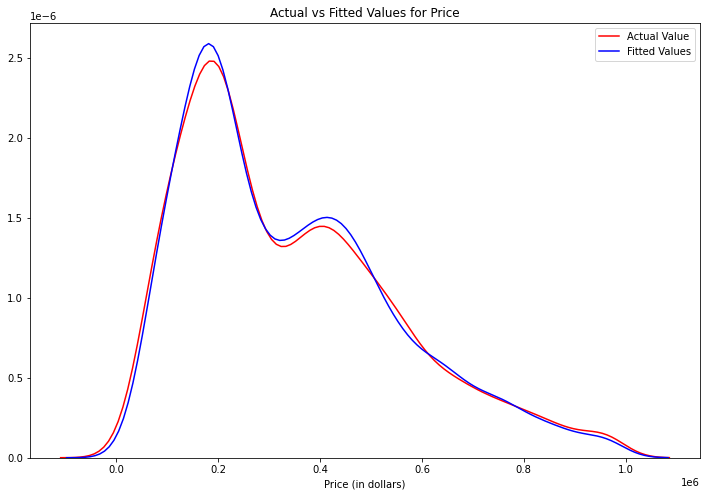

In [27]:
plot_com(train_set[label], tree_predictions)

### Deep Neural Network Regression Model

In [28]:
# import normalized data for DNN model

path = "../input/toshima-data/toshimaku_data_norm_1m.csv"

norm_data = pd.read_csv(path, index_col=0)

norm_dataset = norm_data.copy()
norm_dataset.head(2)

,distance_to_station,area,maximum_coverage_ratio,maximum_floor_area_ratio,building_age,price
0,0.08,0.011628,1.0,0.555556,0.472973,0.114153
1,0.11,0.023256,1.0,0.333333,0.135135,0.164486


In [29]:
# features

X = dataset.iloc[:, :5]
print(X.head())

# labels

Y = dataset.iloc[:, -1]
print(Y.head())

   distance_to_station  area  maximum_coverage_ratio  \
0                    8    15                     0.8   
1                   11    20                     0.8   
2                    9    20                     0.8   
3                   10    20                     0.8   
4                   11    20                     0.8   

   maximum_floor_area_ratio  building_age  
0                       6.0            35  
1                       4.0            10  
2                       5.0             8  
3                       4.0            16  
4                       4.0            10  
0    116400.0
1    164900.0
2    281300.0
3    135800.0
4    174600.0
Name: price, dtype: float64


In [30]:
X_arr = X.values
Y_arr = Y.values

print("X_arr shape: ", X_arr.shape)
print("Y_arr shape: ", Y_arr.shape)

X_arr shape:  (7374, 5)
Y_arr shape:  (7374,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.1, shuffle = True, random_state=0)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (6636, 5)
y_train shape:  (6636,)
X_test shape:  (738, 5)
y_test shape:  (738,)


In [32]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [33]:
def dnn_model():
    
    model = Sequential([
        Dense(10, input_shape = (5,), activation = "relu"),
        Dense(20, activation = "relu"),
        Dense(5, activation = "relu"),
        Dense(1)])

    model.compile(
        optimizer = "rmsprop", 
        loss = root_mean_squared_error, 
        metrics = ["accuracy"])
    
    return model

dnn_reg = dnn_model()
dnn_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


In [34]:
early_stopping = EarlyStopping(monitor="val_loss", patience = 5)

preds_on_untrained = dnn_reg.predict(X_test)

history = dnn_reg.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping],
    verbose = 0
)

In [35]:
print(history.history["loss"])

[402435.34375, 400699.71875, 393944.6875, 376537.9375, 343709.9375, 287361.375, 211729.65625, 162978.734375, 157969.984375, 155404.0625, 152797.703125, 151398.46875, 148714.5, 147452.5, 145535.90625, 144572.078125, 142930.015625, 141433.375, 140426.421875, 140112.796875, 139250.171875, 138327.5625, 138242.046875, 137494.203125, 136717.234375, 136689.90625, 136035.78125, 135247.96875, 134798.96875, 134854.71875, 133890.34375, 133552.15625, 132964.328125, 133218.140625, 132698.5, 132647.296875, 131934.484375, 131776.015625, 131257.71875, 131665.3125, 131183.359375, 130817.15625, 130328.6640625, 130204.84375, 130091.1484375, 129876.65625, 129442.1328125, 129655.3671875, 129349.9921875, 129056.28125, 129323.9765625, 128506.1953125, 128879.5625, 128978.5546875, 128578.953125, 128660.5625, 128583.6640625, 127798.6953125, 127884.1796875, 127486.5234375, 127670.484375, 126984.8984375, 127330.1640625, 127523.4140625, 126663.3359375, 127309.21875, 126883.03125, 126537.1171875, 127079.9375, 12571

The dnn_reg model's prediction error dropped from USD 402,555 after the 1st epoch to USD 128,591 in the 100th epoch.

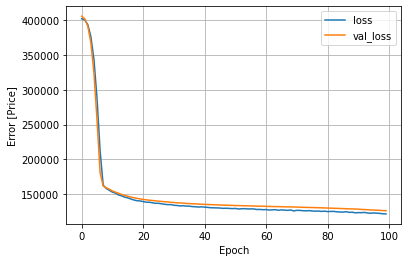

In [36]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Price]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [37]:
price_max = dataset["price"].max()
print(price_max)
price_min = dataset["price"].min()
print(price_min)

def convert_price_values(pred):
    return int((pred*(price_max-price_min) + price_min))

970000.0
6402.0


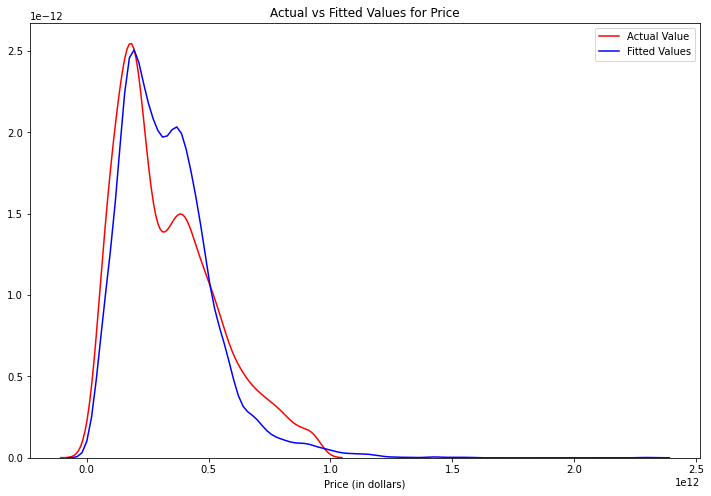

In [38]:
preds = dnn_reg.predict(X_train)

price_preds = [convert_price_values(y) for y in preds]
price_labels = [convert_price_values(y) for y in y_train]
plot_com(price_labels, price_preds)